notice(2): Group "all" created containing 256 particles
notice(2): constrain.rigid(): Creating 256 rigi

*Warning*: Integrator #0: Anisotropic integration requested, but no rotational degrees of freedom found for its group


d bodies (adding 1024 particles)
notice(2): Group "rigid_center" created containing 256 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1280
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes
** starting run **
Time 00:00:00 | Step 100 / 100 | TPS 504.862 | ETA 00:00:00
Average TPS: 501.645
---------
-- Neighborlist stats:
0 normal updates / 0 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 0 / n_neigh_avg: 0
shortest rebuild period: 100
-- Cell list stats:
Dimension: 0, 0, 0
** run complete **


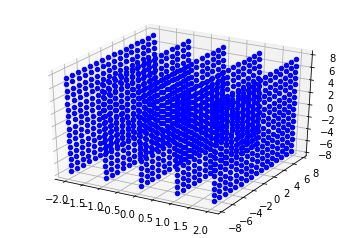

In [19]:
#Our original contribution will be in the form of a hard particle Monte Carlo
#simulation. The idea here is to use the HOOMD (Monte Carlo package) library
#to generate a rigid lattice with charged particles, and calculate
#the strain on the lattice when an external electric field is applied.
#Using this method we can draw some conclusions about the inverse piezo-
#electric effect where an electric field produced mechanical strain on the
#system.

#Team Catastrophe
#Joshua Milem & Anna Turnbull

from hoomd import *
import hoomd.md as md
import numpy as np
from pylab import *

hoomd.context.initialize("CPU");

#Creating our lattice. 16 x 16 2D sheet

unit_cell = hoomd.lattice.unitcell(N = 1, 
                                  a1 = [12,0,0],
                                  a2 = [0,1,0],
                                  a3 = [0,0,1],
                                  dimensions = 3,
                                  position = [[0,0,0]],
                                  type_name = ['R'],
                                  mass = [147.84558],
                                  moment_inertia = [[0,
                                                    1/12*1.0*8**2,
                                                    1/12*1.0*8**2]],
                                  orientation = [[1,0,0,0]]);
system = hoomd.init.create_lattice(unitcell=unit_cell, n=[1,16,16])

system.particles.types.add('A')
n1 = md.nlist.cell()
all = group.all()

#Create rigid bodies on either side of the 2D sheet to simulate crystal

crystallize = hoomd.md.constrain.rigid()
crystallize.set_param('R', types=['A']*4,
                     positions=[(-2,0,0),(-1,0,0),(1,0,0),(2,0,0)])


crystallize.create_bodies()

crystal = hoomd.group.rigid_center()

#NVT thermostat integration, may switch to Brownian to fix anisotropy error

md.integrate.mode_standard(dt=0.005)
md.integrate.nvt(crystal, kT=1.0, tau=0.05)

run(100)



%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

snapshot = system.take_snapshot(all=True)
pos = snapshot.particles.position

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
for part in pos:
    ax.scatter(part[0], part[1], part[2], c='b')
plt.show()



#Currently the issue is coupling the free particle layer to the rigid bodies.
#I do not think this will take much work, I just ran out of time for this 
#piece of the project. 

#HOOMD has an internal energy minimization function which will be used
#to calculate the final energy once the electric strain is applied,
#otherwise strain will be inaccurate.
